In [1]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- 데이터는 id, keyword, location, text, target 등 총 5개 변수로 이루어져 있습니다.
- id - 각 트위터 데이터의 식별자
- keyword - 해당 트윗의 특정 키워드
- location - 트위터가 작성된 장소
- text - 실제 트윗의 메시지
- target - 트위터가 실제로 재난이라면 1, 가짜라면 0으로 표시

In [3]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


- test 데이터에 target 변수 명이 없는 것을 확인할 수 있음

## 탐색적 자료 분석

<ipython-input-4-68b5ad668110>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


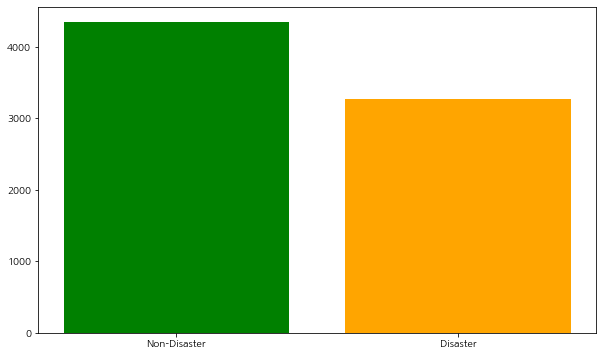

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
news_class = train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, news_class, color=['green', 'orange'])

fig.show()

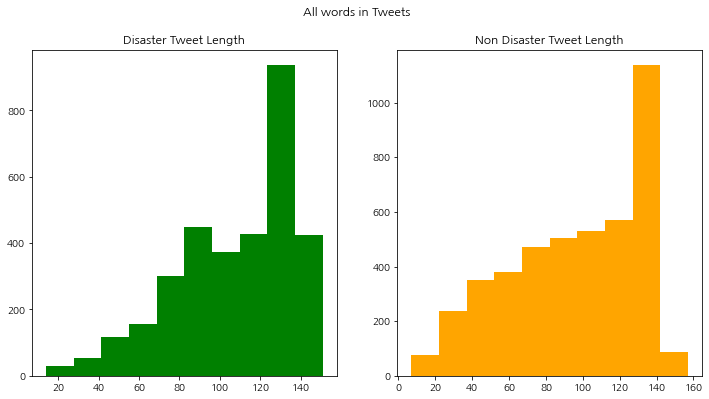

In [5]:
# 트윗 데이터 시각화
disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(disaster_tweet_len, color='green')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()

- 길이가 140 이후 Non Disaster는 급격하게 떨어지는 것을 확인

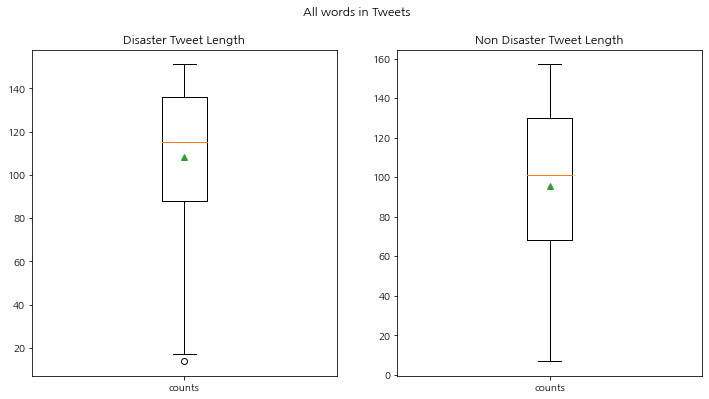

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans=True)
ax[0].set_title('Disaster Tweet Length')

ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans=True)
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()


- 두 데이터 모두 중간값보다 작은 값을 나타내는 것을 확인할 수 있음

In [7]:
## Numpy 활용
import numpy as np

disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

print('Max Length of Disaster Tweet: {}'.format(np.max(disaster_tweet_len)))
print('Min Length of Disaster Tweet: {}'.format(np.min(disaster_tweet_len)))
print('Mean Length of Disaster Tweet: {}'.format(np.mean(disaster_tweet_len)))
print('Median Length of Disaster Tweet: {}'.format(np.median(disaster_tweet_len)))

print('Max Length of Non Disaster Tweet: {}'.format(np.max(non_disaster_tweet_len)))
print('Min Length of Non Disaster Tweet: {}'.format(np.min(non_disaster_tweet_len)))
print('Mean Length of Non Disaster Tweet: {}'.format(np.mean(non_disaster_tweet_len)))
print('Median Length of Non Disaster Tweet: {}'.format(np.median(non_disaster_tweet_len)))

Max Length of Disaster Tweet: 151
Min Length of Disaster Tweet: 14
Mean Length of Disaster Tweet: 108.11342097217977
Median Length of Disaster Tweet: 115.0
Max Length of Non Disaster Tweet: 157
Min Length of Non Disaster Tweet: 7
Mean Length of Non Disaster Tweet: 95.70681713496084
Median Length of Non Disaster Tweet: 101.0


<ipython-input-8-cdc058eae20e>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


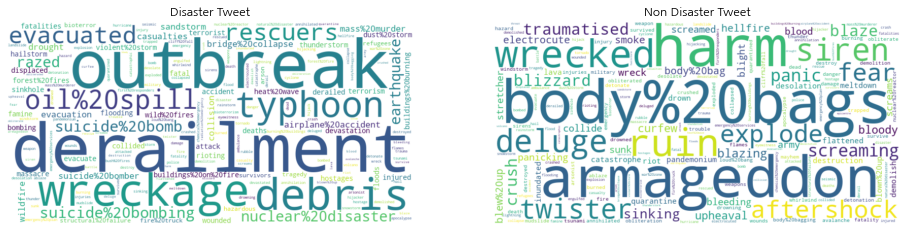

In [8]:
## wordcloud 활용
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target']==1]['keyword'].value_counts())
non_disaster_tweet_keywords = dict(train[train['target']==0]['keyword'].value_counts())

stopwords=set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(disaster_tweet_keywords)

non_disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(non_disaster_tweet_keywords)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')

ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')

fig.show()

- Disaster 트윗은 Derailment(탈선), Outbreak(어떤 사건의 발생), Wreckage(난파), Typhoon(태풍) 등
     명사 하나로도 충분하게 설명되는 진짜 재난 뉴스인 반면
- Non Disaster 트윗은 명사보단 형용사나 동사가 주로 사용되는 것을 확인할 수 있음

## 피처 엔지니어링

In [9]:
# 결측치 확인
import pandas as pd
def check_na(data):
    isnull_na = (data.isnull().sum()/len(data))*100
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False)
    missing_data=pd.DataFrame({'Missing Ratio': data_na,
                                'Data Type': data.dtypes[data_na.index]})
    print('결측치 데이터 칼럼과 건수:\n', missing_data)

check_na(train)
check_na(test)

결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


- 독립 변수로 활용할 text 변수에는 결측치가 없음을 확인할 수 있음

In [10]:
# test_id만 따로 추출해 저장
test_id = test['id']
for datas in [train, test]:
    datas = datas.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
    
train.shape, test.shape

((7613, 2), (3263, 1))

### Text Cleansing
- HTML 태그 제거
- 특수문자 공백으로 바꾸기
- 대문자 소문자로 바꾼 후, 리스트로 만들기
- 불용어 제거하기


In [11]:
# url 제거
# re.sub 메소드를 활용하여 공백으로 만들면 제거 가능
import re


def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)


sample_text = "새로운 캐글 대회가 열렸습니다. 주소: https://www.kaggle.com/c/nlp-getting-started"
remove_url(sample_text)


'새로운 캐글 대회가 열렸습니다. 주소: '

In [12]:
# html 제거
'''
일정한 표현식에 따라서 정규 표현식을 작성할 수 있고, 
이를 활용해 특정 문자열의 패턴을 찾아내서 제거하는 원리입니다.
'''
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)


sample_text = """<div>
<h1> Real News or Fake News </h1>
<p> Kaggle Machine Learning </p>
</div>"""

print(remove_html(sample_text))



 Real News or Fake News 
 Kaggle Machine Learning 



In [13]:
!pip install emoji --upgrade

In [14]:
import emoji
print(emoji.emojize('Phd is very easy!!! :thumbs_up:'))


Phd is very easy!!! 👍


In [15]:
# 영어가 아닌 특수 문자를 공백으로 바꿈
def remove_emoji(text):
  emoji_pattern = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)


remove_emoji("Hello, 👍")


'Hello, '

In [16]:
# '#'을 제거하는지 확인
def remove_punct(text):
  return re.sub("[^a-zA-Z]", " ", text)


sample_text = "Hello!, Can I have one question?.., Is it #Outbreak?"
remove_punct(sample_text)


'Hello   Can I have one question     Is it  Outbreak '

In [17]:
# NLTK
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

print("Total Length of stopwords:", len(stopwords.words('english')))
print(stopwords.words('english')[:10])


Total Length of stopwords: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wkddn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text Transformation Vectorizer

In [18]:
# Countvectorizer
'''
각각의 텍스트 데이터를 분할해 단순하게 몇 번 나왔는지 숫자를 세는 개념
Jangwoon은 인덱스의 2번에 위치하는 것을 알 수 있습니다.
근데 array로 변환한 값을 보면 숫자 2로 표시가 되는데, 
이는 Jangwoon이 두 번 나타난다는 의미입니다.
'''
from sklearn.feature_extraction.text import CountVectorizer
corpus = ['Hi, My name is Jangwoon. Jangwoon']
vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)


[[1 1 2 1 1]]
{'hi': 0, 'my': 3, 'name': 4, 'is': 1, 'jangwoon': 2}


In [19]:
corpus = ["Urban Jungle, steppin' on a puddle Mind race ejaculate the thoughts that's in the bubble"] # Manila 가사
vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)


[[1 1 1 1 1 1 1 1 1 1 2 1 1]]
{'urban': 12, 'jungle': 3, 'steppin': 8, 'on': 5, 'puddle': 6, 'mind': 4, 'race': 7, 'ejaculate': 1, 'the': 10, 'thoughts': 11, 'that': 9, 'in': 2, 'bubble': 0}


In [20]:
# TfidfVectorizer
# 단어의 빈도와 역 문서(문장) 빈도를 사용해 문서(문장) 내의 각 단어마다 가중치를 부여하는 것
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["Workin' for the better 'morrow, workin' for the payday",
          "Rememberin' the things that's in the past that's in the heyday",
          "Way way, back back, when when, time right",
          "Sneakers so white white, comin' through the city"
          ]  # Manila 가사
tfidfv = TfidfVectorizer().fit(corpus)
print(np.round(tfidfv.transform(corpus).toarray(), 2))
print(tfidfv.vocabulary_)


[[0.   0.28 0.   0.   0.56 0.   0.   0.28 0.   0.28 0.   0.   0.   0.
  0.   0.36 0.   0.   0.   0.   0.   0.   0.56]
 [0.   0.   0.   0.   0.   0.25 0.51 0.   0.25 0.   0.25 0.   0.   0.
  0.51 0.48 0.25 0.   0.   0.   0.   0.   0.  ]
 [0.53 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.27 0.   0.
  0.   0.   0.   0.   0.27 0.53 0.53 0.   0.  ]
 [0.   0.   0.33 0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.33 0.33
  0.   0.21 0.   0.33 0.   0.   0.   0.65 0.  ]]
{'workin': 22, 'for': 4, 'the': 15, 'better': 1, 'morrow': 7, 'payday': 9, 'rememberin': 10, 'things': 16, 'that': 14, 'in': 6, 'past': 8, 'heyday': 5, 'way': 19, 'back': 0, 'when': 20, 'time': 18, 'right': 11, 'sneakers': 12, 'so': 13, 'white': 21, 'comin': 3, 'through': 17, 'city': 2}


In [21]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def data_cleansing(text, remove_stopwords = False):
  # remove url 
  url = re.compile(r'https?://\S+|www\.\S+')
  cleaned_text = url.sub(r'', text)

  # remove html
  html = re.compile(r'<.*?>')
  cleaned_text = html.sub(r'', cleaned_text)

  # remove emoji
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  cleaned_text = emoji_pattern.sub(r'', cleaned_text)

  # Special Letters to empty space
  cleaned_text = re.sub("[^a-zA-Z]", " ", cleaned_text)

  # Lowercase
  cleaned_text = cleaned_text.lower().split()

  if remove_stopwords:
    stops = set(stopwords.words("english"))
    cleaned_text = [word for word in cleaned_text if not word in stops]
    clean_review = ' '.join(cleaned_text)
  else:
    clean_review = ' '.join(cleaned_text)

  return clean_review

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wkddn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
clean_train_reviews = []
for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(
        lambda x: data_cleansing(x, remove_stopwords=True))

train.head(5)


,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [23]:
test.head(5)


,text,cleaned_text
0,Just happened a terrible car crash,happened terrible car crash
1,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


## Modeling

### Data Split

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [25]:
# TfidfVectorizer 클래스 활용
# 최종 변환된 데이터를 x 객체로 저장, 종족 변수인 target을 y 값으로 저장
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char',
                             sublinear_tf=True, ngram_range=(1, 3), max_features=10000)
X = vectorizer.fit_transform(train['cleaned_text']).todense()
y = train['target'].values


In [26]:
print(X.shape) # (학습할 데이터, 현재 데이터에 사용된 전체 단어의 개수)
print(y.shape)

(7613, 9444)
(7613,)


In [27]:
# 훈련 데이터와 검증 데이터로 분류

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((5329, 9444), (2284, 9444), (5329,), (2284,))

### Modeling

In [28]:
# 로지스틱 회귀 모델을 적용해 모형 학습
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight='balanced') 
lgs.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

In [29]:
# Test
X_testset = vectorizer.transform(test['cleaned_text']).todense()
print("The Shape of Test Dataset:", X_testset.shape)

y_test_pred = lgs.predict(X_testset)
print("The Predict Value:", y_test_pred)
y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)
print("The Predict Class:", y_test_pred)

submission_file = pd.DataFrame({'id': test_id, 'target': y_test_pred})
print(submission_file.head())

submission_file.to_csv('submission_lgs_20211229.csv', index=False)


The Shape of Test Dataset: (3263, 9444)
The Predict Value: [1 0 1 ... 1 1 1]
The Predict Class: [1 0 1 ... 1 1 1]
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1


### Validation

In [30]:
y_pred_lgs = lgs.predict(X_valid)

In [31]:
confusion_matrix(y_valid, y_pred_lgs)

array([[1090,  248],
       [ 233,  713]], dtype=int64)

In [32]:
print("Accuracy: {}".format(accuracy_score(y_valid, y_pred_lgs)))


Accuracy: 0.7894045534150613


In [33]:
f1_score(y_valid, y_pred_lgs)

0.7477713686418458

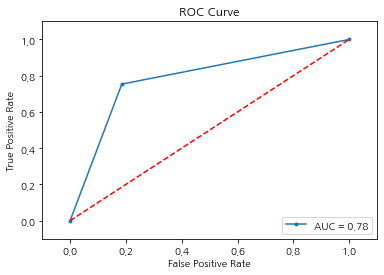

In [34]:
fpr, tpr, _ = roc_curve(y_valid, y_pred_lgs)
auc_score = auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, marker='.', label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance
# scores lie (i.e. just flipping a coin)
plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


### Submit

In [35]:
X_testset = vectorizer.transform(test['cleaned_text']).todense()


In [36]:
print(X_testset.shape)


(3263, 9444)


In [37]:
y_test_pred = lgs.predict(X_testset)


In [38]:
import numpy as np
y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)
y_test_pred


array([1, 0, 1, ..., 1, 1, 1])

In [39]:
submission_file = pd.DataFrame({'id': test_id, 'target': y_test_pred})
submission_file

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [40]:
submission_file.to_csv('submission_lgs_20211229_2.csv', index=False)


## Evaluation

### Confusion Metrics (혼동 행렬)


![](https://blog.kakaocdn.net/dn/bYy2ck/btqyuEJMtta/3qkcbPk3rQiic6J7mHVWQ0/img.png)

- True Positive(TP): 모형은 암이다 예측, 실제로도 암이었음
- True Negative(TN): 모형은 암이 아니다 예측, 실제로도 암이 아니었음
- False Positive(FP): 모형은 암이다 예측, 실제로는 아니었음
- False Negative(FN): 모형은 암이 아니다 예측, 실제로는 암이었음


In [41]:
# 참 양성
def true_positive(y_true, y_pred):
  tp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 1:
      tp += 1
  return tp

# 참 음성
def true_negative(y_true, y_pred):
  tn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 0:
      tn += 1
  return tn

# 긍정 오류
def false_positive(y_true, y_pred):
  fp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 1:
      fp += 1
  return fp

# 부정 오류
def false_negative(y_true, y_pred):
  fn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 0:
      fn += 1
  return fn


y_true = [0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
y_pred = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0]

print("True Negative {}".format(true_negative(y_true, y_pred)))
print("False Positive {}".format(false_positive(y_true, y_pred)))
print("False Negative {}".format(false_negative(y_true, y_pred)))
print("True Positive {}".format(true_positive(y_true, y_pred)))


True Negative 4
False Positive 1
False Negative 3
True Positive 2


- 1은 양성을 의미, 0은 음성을 의미한다고 가정
- 실젯값이 1일 때 예측값이 1인 경우는 2번
- 실젯값이 0일 때 예측값이 0인 경우는 4번

In [42]:
# confusion_matrix() API
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[4, 1],
       [3, 2]], dtype=int64)

In [43]:
# Tuple 형태로 결과값 저장
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp


(4, 1, 3, 2)

### 정확도 (Accuracy)
- 전체 데이터 수를 실젯값과 예측값이 동일한 개수로 나눈 비율

In [44]:
def accuracy_v2(y_true, y_pred):
  tp = true_positive(y_true, y_pred)
  tn = true_negative(y_true, y_pred)
  fp = false_positive(y_true, y_pred)
  fn = false_negative(y_true, y_pred)

  accuracy_score = (tp + tn) / (tp + tn + fp + fn)
  return accuracy_score


print(round(accuracy_v2(y_true, y_pred), 2))


0.6


#### Precision (정밀도)
- 총 100개의 이미지
- 90개는 정상 이미지 / 10개는 암진단 이미지
+ 정상 이미지 중 80개는 정상으로 예측, 10개는 암으로 예측(오류)
+ 암 진단 이미지 중 8개는 암으로 예측, 2개는 정상으로 예측(오류)
- 계산하면, 다음과 같다.
+ TP: 8개
+ TN: 80개
+ FP: 10개
+ FN: 2개

![](https://blog.kakaocdn.net/dn/bYy2ck/btqyuEJMtta/3qkcbPk3rQiic6J7mHVWQ0/img.png)

- Precision = TP / (TP + FP)
+ 모형이 양성이라고 예측한 것 중에서, 실제로 양성인 것
+ 양성으로 예측한 것 중에서 실제로 양성으로 예측한 비율은 8 / (8 + 10) = 0.444
+ Precision을 올리기 위해서는 TP를 올리거나 FP를 내려야 함
+ 예측 성능의 모델의 입장에서 보는 것


In [45]:
from sklearn.metrics import precision_score


def precision(y_true, y_pred):
  tp = true_positive(y_true, y_pred)
  fp = false_positive(y_true, y_pred)

  precision = tp / (tp + fp)
  return precision


print("user function:", precision(y_true, y_pred))
print("scikit-learn function:", precision_score(y_true, y_pred))


user function: 0.6666666666666666
scikit-learn function: 0.6666666666666666


#### Recall (재현율)
- 실제 양성 중에서, 모델이 양성이라고 예측한 것
- Recall = TP / (TP + FN) = 8 / (8 + 2)


In [46]:
from sklearn.metrics import recall_score


def recall(y_true, y_pred):
  tp = true_positive(y_true, y_pred)
  fn = false_negative(y_true, y_pred)

  recall = tp / (tp + fn)
  return recall


print("user function:", recall(y_true, y_pred))
print("scikit-learn function:", recall_score(y_true, y_pred))


user function: 0.4
scikit-learn function: 0.4


- 좋은 모델은 정밀도와 재현율이 모두 높아야 한다.

#### Threshold
- 분류는 보통 확률값으로 우선 먼저 떨어지고, 그 다음에 임계값을 정한다.
- Default는 보통 0.5이다.


In [47]:
import numpy as np
y_true = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
y_pred = np.random.rand(20)
print(y_pred)

len(y_true), len(y_pred)


[0.42292573 0.0447443  0.00296723 0.2829075  0.56826865 0.80625444
 0.66496487 0.27723196 0.90349325 0.36529175 0.97800972 0.4737312
 0.7630103  0.31268294 0.94067651 0.66300552 0.68877008 0.51362966
 0.41484018 0.11193335]


(20, 20)

In [48]:
# 각 threshold의 값에 따라 재현율과 정밀도가 어떻게 달라지는지 확인

import matplotlib.pyplot as plt
import pandas as pd

precisions = []
recalls = []

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in thresholds:
  temp_prediction = [1 if x >= i else 0 for x in y_pred]
  p = precision(y_true, temp_prediction)
  r = recall(y_true, temp_prediction)

  precisions.append(p)
  recalls.append(r)

print(pd.DataFrame({"threshold": thresholds,
      "Precision": precisions, "Recall": recalls}))



   threshold  Precision    Recall
0        0.1   0.166667  1.000000
1        0.2   0.176471  1.000000
2        0.3   0.133333  0.666667
3        0.4   0.153846  0.666667
4        0.5   0.100000  0.333333
5        0.6   0.125000  0.333333
6        0.7   0.200000  0.333333
7        0.8   0.250000  0.333333
8        0.9   0.333333  0.333333


<ipython-input-49-3af6f7d106c7>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


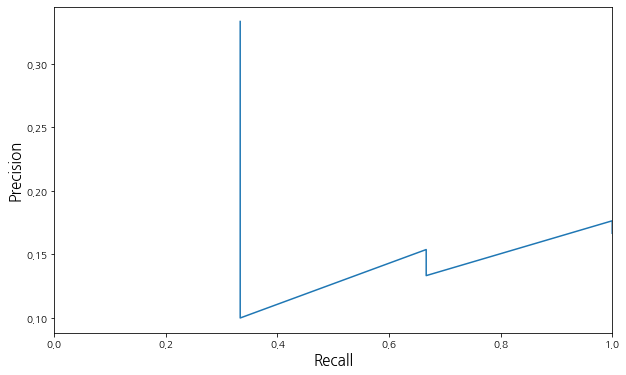

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(recalls, precisions)
ax.set_xlabel('Recall', fontsize=15)
ax.set_ylabel('Precision', fontsize=15)
ax.set_xlim(0, 1.0)
fig.show()


> 임계값을 어떻게 설정하느냐에 따라 정밀도와 재현율의 값이 달라진다.
- https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall


#### F1 Score
- Precision & Recall의 가중 평균(Weighted Average)
- P: Precision(정밀도)
- R: Recall(재현율)
- 공식은 다음과 같다.
+ F1 = 2PR / (P + R)
+ F1 = 2TP / (2TP + FP + FN)


In [53]:
def f1(y_true, y_pred):
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)
  score = 2 * p * r / (p + r)
  return score

y_true = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

y_pred = [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

f1(y_true, y_pred)


0.5714285714285715

In [54]:
from sklearn import metrics
print(metrics.f1_score(y_true, y_pred))

0.5714285714285715


- 종속변수의 라벨이 주로 불균형을 이룰 때에는 Accuracy 보다는 F1 스코어를 주요 평가 지표로 삼는다.
- F1 스코어가 1에 가까울수록 좋은 모델이라고 평가한다.


### ROC 곡선과 AUC

In [58]:
# AUC
def tpr(y_true, y_pred):
  return recall(y_true, y_pred)


def fpr(y_true, y_pred):
  fp = false_positive(y_true, y_pred)
  tn = true_negative(y_true, y_pred)
  return fp / (tn + fp)


    threshold  fpr  tpr
0        0.00  1.0  1.0
1        0.10  0.9  1.0
2        0.20  0.7  1.0
3        0.30  0.6  0.8
4        0.40  0.3  0.8
5        0.50  0.3  0.8
6        0.60  0.2  0.8
7        0.70  0.1  0.6
8        0.80  0.1  0.6
9        0.85  0.1  0.4
10       0.90  0.0  0.4
11       0.99  0.0  0.2
12       1.00  0.0  0.0


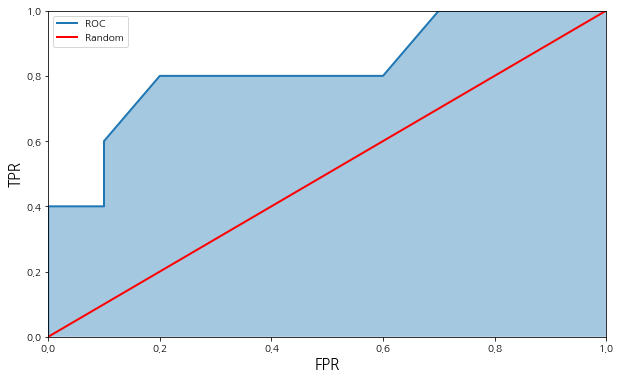

In [59]:
# ROC
import pandas as pd
import matplotlib.pyplot as plt

tpr_list = []
fpr_list = []
auc_list = []

y_true = [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05, 0.9,
          0.5, 0.3, 0.66, 0.3, 0.2, 0.85, 0.15, 0.99]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.99, 1.0]


for thresh in thresholds:
  temp_pred = [1 if x >= thresh else 0 for x in y_pred]
  temp_tpr = tpr(y_true, temp_pred)
  temp_fpr = fpr(y_true, temp_pred)
  temp_fpr = round(temp_fpr, 1)
  tpr_list.append(temp_tpr)
  fpr_list.append(temp_fpr)

print(pd.DataFrame({"threshold": thresholds,
                    "fpr": fpr_list,
                    "tpr": tpr_list}))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(fpr_list, tpr_list, alpha=0.4)
ax.plot(fpr_list, tpr_list, lw=2, label='ROC')
plt.plot([0, 1], [0, 1], lw=2, color='r', label='Random')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_xlabel("FPR", fontsize=15)
ax.set_ylabel("TPR", fontsize=15)
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import roc_auc_score

y_true = [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05, 0.9,
          0.5, 0.3, 0.66, 0.3, 0.2, 0.85, 0.15, 0.99]

print("AUC:", roc_auc_score(y_true, y_pred))


AUC: 0.8300000000000001


- AUC에 관한 결과 해석
 + AUC = 1.0: 가장 좋은 모델
 + AUC = 0.5: 직관적으로, 인간이 직접 분류하는 것과 차이가 없거나 더 못한 경우
 + AUC = 0.0: 데이터 전처리 및 학습에 문제가 생긴 것
